## Dimensionality reduction using spatially aware autoencoders

In this tutorial we will learn spatially aware representations of the DLPFC human brain cortex data using autoencoders.

In [1]:
import numpy as np
import torch
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

from smoother import SpatialWeightMatrix, SpatialLoss, ContrastiveSpatialLoss
from smoother.models.reduction import SpatialPCA, SpatialAutoEncoder

import scanpy as sc
import anndata

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


### Load the brain cortex dataset (preprocessed)

Here the expression data is truncated to keep only the top marker genes. Alternatively, a preprocessed `anndata.AnnData` object can be directly supplied to the autoencoder.

In [2]:
# change the data directory accordingly
DATA_DIR = "./data/"

# layer annotation
anno_true = pd.read_csv(DATA_DIR + "DLPFC_151673_layer_annotation.txt", sep = " ", header=0)
anno_true.index = anno_true.index.str.split('.').str[0]

# read in log_count matrices
# spatial log-normalized count matrix, num_gene x num_spot
y_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp.txt", sep = " ", header=0)
y_df = y_df.loc[:,anno_true.index]

# spatial coordinates, num_spot x 2
# here we are using 10x Visium's pixel-level coordinates
# i.e., 'pxl_col_in_fullres' and 'pxl_row_in_fullres'
coords = pd.read_csv(DATA_DIR + "DLPFC_151673_coords.txt", sep = " ", header=0)
coords = coords.loc[y_df.columns,:]

# create the anndata object
adata = anndata.AnnData(
    X = y_df.T.values, 
    obs = anno_true,
    obsm = {'spatial': coords.values}
)
adata.layers['log1p'] = adata.X.copy()
sc.pp.scale(adata, layer='log1p', zero_center=True, max_value=10, copy=False)
adata.layers['scaled'] = adata.X.copy()

print(f"Number of genes: {adata.shape[1]}")
print(f"Number of spots: {adata.shape[0]}")
print("Layer spot counts:")
anno_true.layer.value_counts()

Number of genes: 350
Number of spots: 3611
Layer spot counts:


L3    989
L6    692
L5    673
WM    513
L1    273
L2    253
L4    218
Name: layer, dtype: int64

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


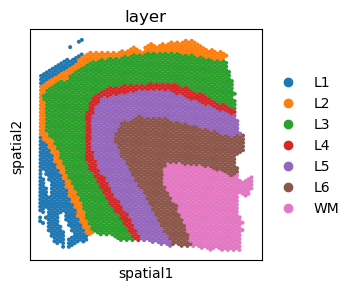

In [3]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis = 'spatial', color = 'layer')

### Generate the spatial loss functions

In [4]:
# prepare spatial loss
y = adata.layers['log1p']
y = torch.tensor(y).T
coords = adata.obsm['spatial']

weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

sp_loss = SpatialLoss('icar', weights, 0.99, standardize_cov=False)
cont_sp_loss = ContrastiveSpatialLoss('icar', weights, 0.99, standardize_cov=False)

Number of spots: 3611. Average number of neighbors per spot:  5.86.
Number of spots: 3611. Average number of neighbors per spot:  5.86.


### Spatially aware principal component analysis

#### Vanilla PCA - without spatial loss

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


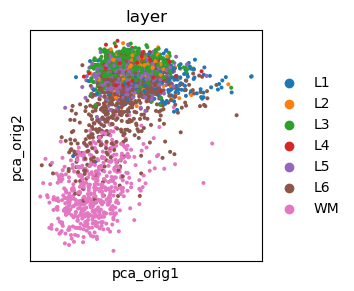

In [5]:
# run PCA
baseline = SpatialPCA(adata, layer='scaled', n_latent=10)
baseline.reduce(lr=1, max_epochs=-1, verbose=False, init_with_svd=True, quite=True)

# extract and visualize embeddings
adata.obsm['pca_orig'] = baseline.get_latent_representation()
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, 'pca_orig', color = 'layer')

#### SpatialPCA - varying regular spatial losses

In [6]:
torch.manual_seed(20230710)
l_sp_losses = [0, 1, 3, 10, 30] # spatial regularization strength

names_list = [f"PCA_sp_{l_sp}" for l_sp in l_sp_losses]
X_latent = [] # latent representations

# for each lambda, train a SpatialPCA model
for l_sp in l_sp_losses:
    model = SpatialPCA.from_rna_model(
        rna_model=baseline, st_adata=adata, layer='scaled',
        spatial_loss=sp_loss, lambda_spatial_loss=l_sp
    )
    model.reduce(lr=1e-1, max_epochs=-1, verbose=False, init_with_svd=False, quite=False)

    # store latent representations
    X_latent.append(model.get_latent_representation())

=== Time  0.31s. Total epoch 165. Final Loss: (total) -9.6778. (recon) -9.6778. (spatial) 0.0000.
=== Time  1.62s. Total epoch 454. Final Loss: (total) -8.3846. (recon) -9.1766. (spatial) 0.7920.
=== Time  18.35s. Total epoch 5254. Final Loss: (total) -7.0057. (recon) -8.8667. (spatial) 1.8610.
=== Time  6.10s. Total epoch 1769. Final Loss: (total) -4.0334. (recon) -7.9715. (spatial) 3.9381.
=== Time  0.11s. Total epoch 32. Final Loss: (total) 36.2752. (recon) -6.3772. (spatial) 42.6523.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:108

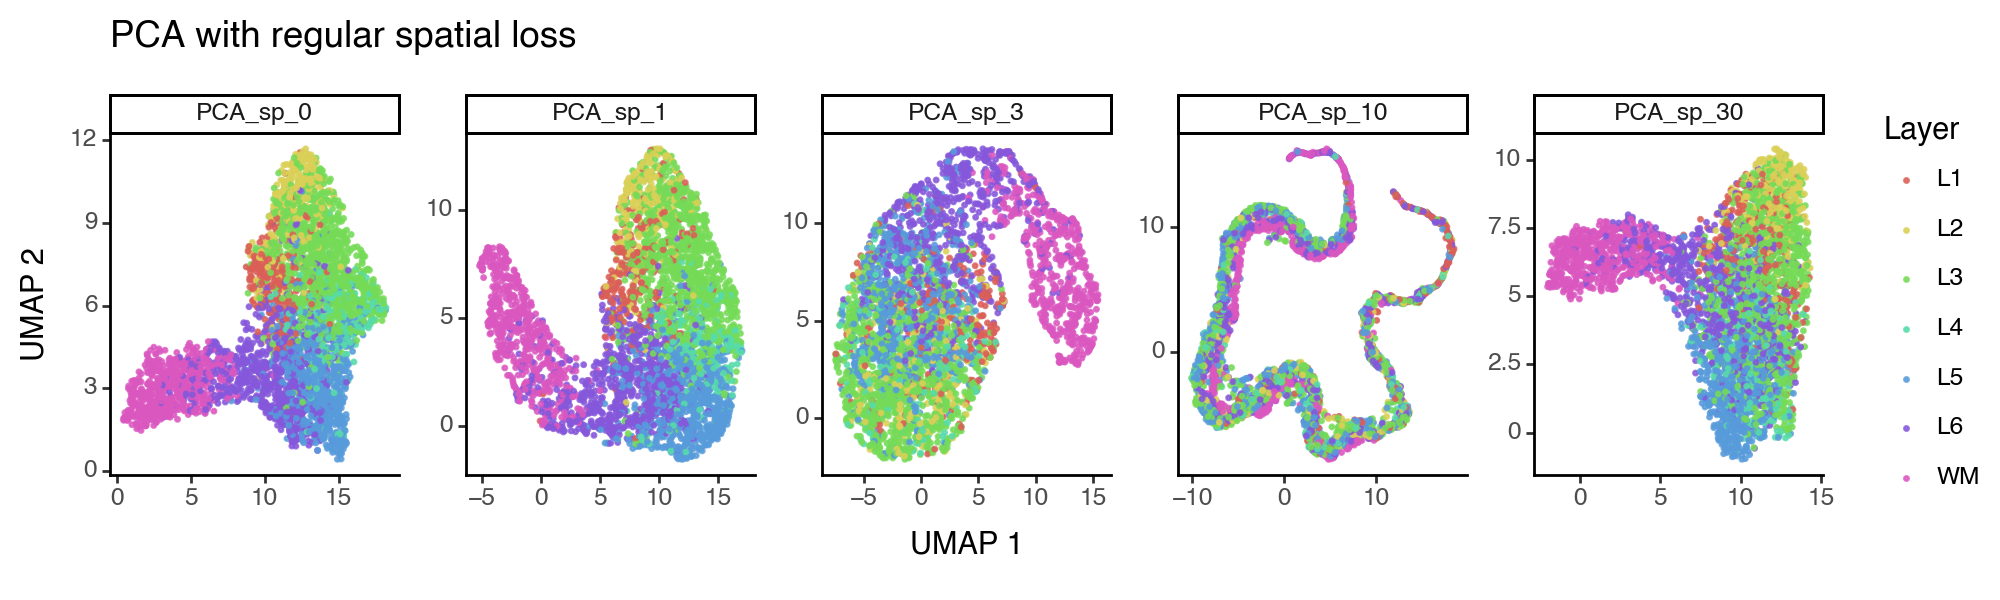

<Figure Size: (1000 x 300)>

In [7]:
# calculate UMAP embeddings
df_umap = []
for name, h in zip(names_list, X_latent):
    adata.obsm[f"X_{name}"] = h
    sc.pp.neighbors(adata, use_rep=f"X_{name}", n_neighbors = 10)
    sc.tl.umap(adata)

    _df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP 1', 'UMAP 2'], index=adata.obs.index)
    _df['name'] = name
    _df['layer'] = adata.obs['layer'].values
    df_umap.append(_df)

df_umap = pd.concat(df_umap)
df_umap['name'] = pd.Categorical(df_umap['name'], categories = names_list)

# visualization
ggplot(df_umap, aes(x = 'UMAP 1', y = 'UMAP 2', color = 'layer')) + \
    facet_wrap('~ name', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'PCA with regular spatial loss', color = 'Layer') + \
    theme(figure_size = (10,3))

#### SpatialPCA - varying contrastive spatial losses

In [8]:
torch.manual_seed(20230710)
l_sp_losses = [0, 1, 3, 10, 30] # spatial regularization strength

names_list = [f"PCA_csp_{l_sp}" for l_sp in l_sp_losses]
X_latent = [] # latent representations

# for each lambda, train a SpatialPCA model
for l_sp in l_sp_losses:
    model = SpatialPCA.from_rna_model(
        rna_model=baseline, st_adata=adata, layer='scaled',
        spatial_loss=cont_sp_loss, lambda_spatial_loss=l_sp
    )
    model.reduce(lr=1e-1, max_epochs=-1, verbose=False, init_with_svd=False, quite=False)

    # store latent representations
    X_latent.append(model.get_latent_representation())

=== Time  0.52s. Total epoch 165. Final Loss: (total) -9.6778. (recon) -9.6778. (spatial) 0.0000.
=== Time  1.36s. Total epoch 37. Final Loss: (total) -10.6024. (recon) -9.6183. (spatial) -0.9841.
=== Time  0.67s. Total epoch 18. Final Loss: (total) -12.5766. (recon) -9.5766. (spatial) -3.0000.
=== Time  0.86s. Total epoch 25. Final Loss: (total) -19.5394. (recon) -9.5394. (spatial) -10.0000.
=== Time  2.19s. Total epoch 87. Final Loss: (total) -39.5744. (recon) -9.5744. (spatial) -30.0000.


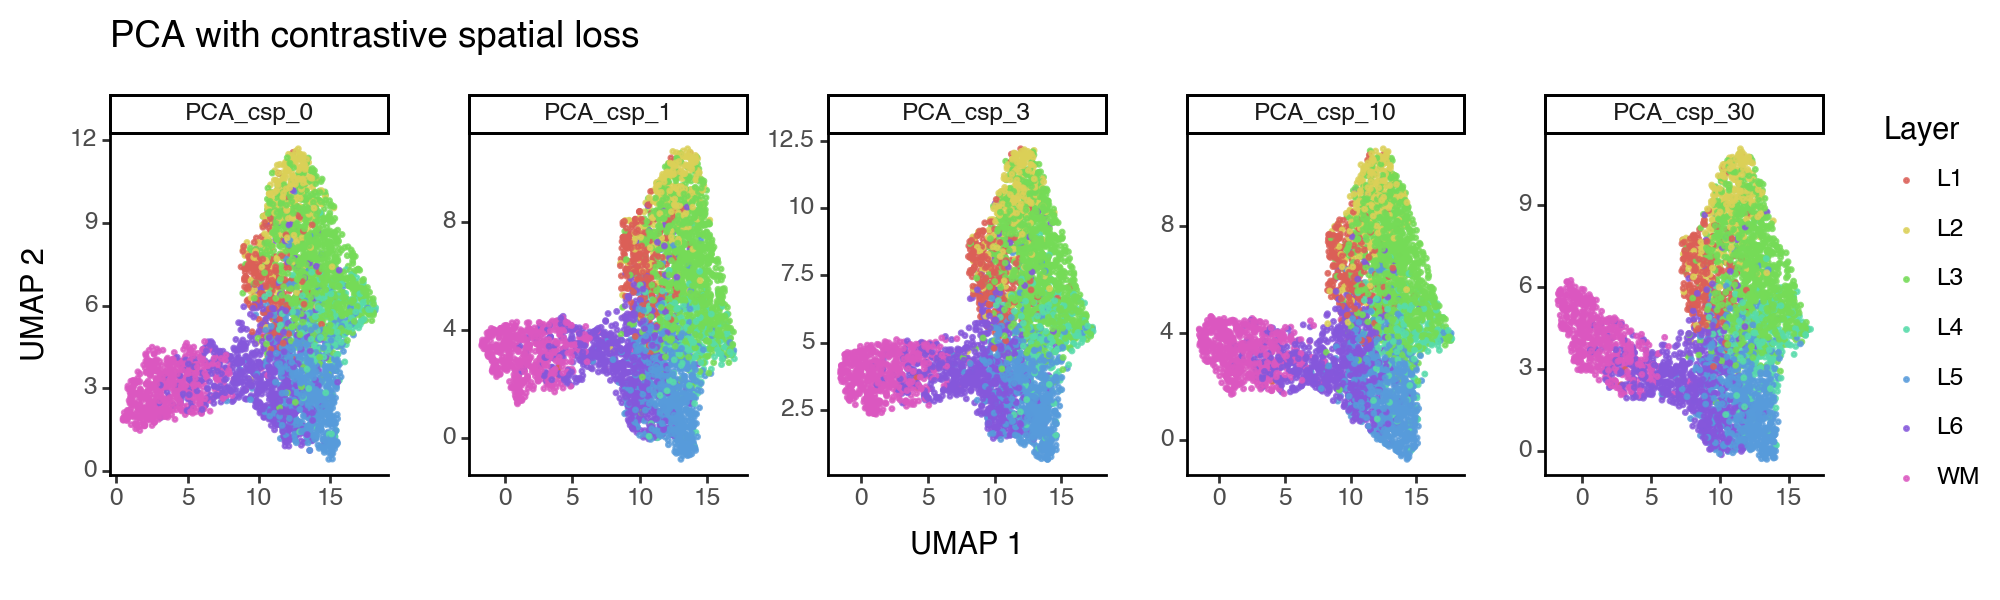

<Figure Size: (1000 x 300)>

In [9]:
# calculate UMAP embeddings
df_umap = []
for name, h in zip(names_list, X_latent):
    adata.obsm[f"X_{name}"] = h
    sc.pp.neighbors(adata, use_rep=f"X_{name}", n_neighbors = 10)
    sc.tl.umap(adata)

    _df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP 1', 'UMAP 2'], index=adata.obs.index)
    _df['name'] = name
    _df['layer'] = adata.obs['layer'].values
    df_umap.append(_df)

df_umap = pd.concat(df_umap)
df_umap['name'] = pd.Categorical(df_umap['name'], categories = names_list)

# visualization
ggplot(df_umap, aes(x = 'UMAP 1', y = 'UMAP 2', color = 'layer')) + \
    facet_wrap('~ name', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'PCA with contrastive spatial loss', color = 'Layer') + \
    theme(figure_size = (10,3))

### Spatially aware autoencoder

Here we set both the encoder and decoder to be 2-layer MLP.

#### SpatialAE - without spatial loss

=== Time  10.12s. Total epoch 200. Final Loss: (total) 1.4106. (recon) 1.3902. (orth) 0.0204. (spatial) 0.0000.


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:226: UserWarning: Fail to converge. Try to increase 'max_epochs'.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


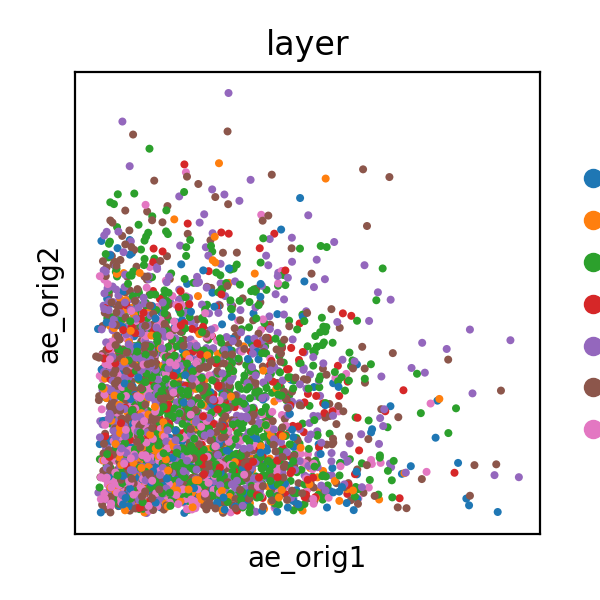

In [10]:
torch.manual_seed(20230710)

# run SpatialAE
baseline = SpatialAutoEncoder(
    adata, layer='log1p', 
    n_layers=2, n_latent=30,
    lambda_orth_loss=0.01,
    recon_loss_mode='mse',
    activation_fn=torch.nn.ELU
)
baseline.reduce(lr = 3e-3, max_epochs=200, verbose=False, quite=False)

# extract and visualize embeddings
adata.obsm['ae_orig'] = baseline.get_latent_representation()
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, 'ae_orig', color = 'layer')

#### SpatialAE - varying regular spatial losses

In [11]:
torch.manual_seed(20230710)
l_sp_losses = [0, 1, 3, 10, 30] # spatial regularization strength

names_list = [f"AE_sp_{l_sp}" for l_sp in l_sp_losses]
X_latent = [] # latent representations

# for each lambda, train a SpatialPCA model
for l_sp in l_sp_losses:
    model = SpatialAutoEncoder.from_rna_model(
        rna_model=baseline, st_adata=adata, layer='log1p',
        spatial_loss=sp_loss, lambda_spatial_loss=l_sp
    )
    model.reduce(lr=3e-4, max_epochs=200, verbose=False, quite=False)

    # store latent representations
    X_latent.append(model.get_latent_representation())

=== Time  0.08s. Total epoch 2. Final Loss: (total) 1.4102. (recon) 1.3898. (orth) 0.0204. (spatial) 0.0000.
=== Time  11.17s. Total epoch 200. Final Loss: (total) 2.2551. (recon) 1.3767. (orth) 0.1400. (spatial) 0.7385.


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:226: UserWarning: Fail to converge. Try to increase 'max_epochs'.


=== Time  10.75s. Total epoch 200. Final Loss: (total) 2.3253. (recon) 1.3743. (orth) 0.2403. (spatial) 0.7107.
=== Time  10.53s. Total epoch 200. Final Loss: (total) 2.8641. (recon) 1.3718. (orth) 0.2706. (spatial) 1.2217.
=== Time  11.00s. Total epoch 200. Final Loss: (total) 3.7752. (recon) 1.3691. (orth) 0.2832. (spatial) 2.1229.


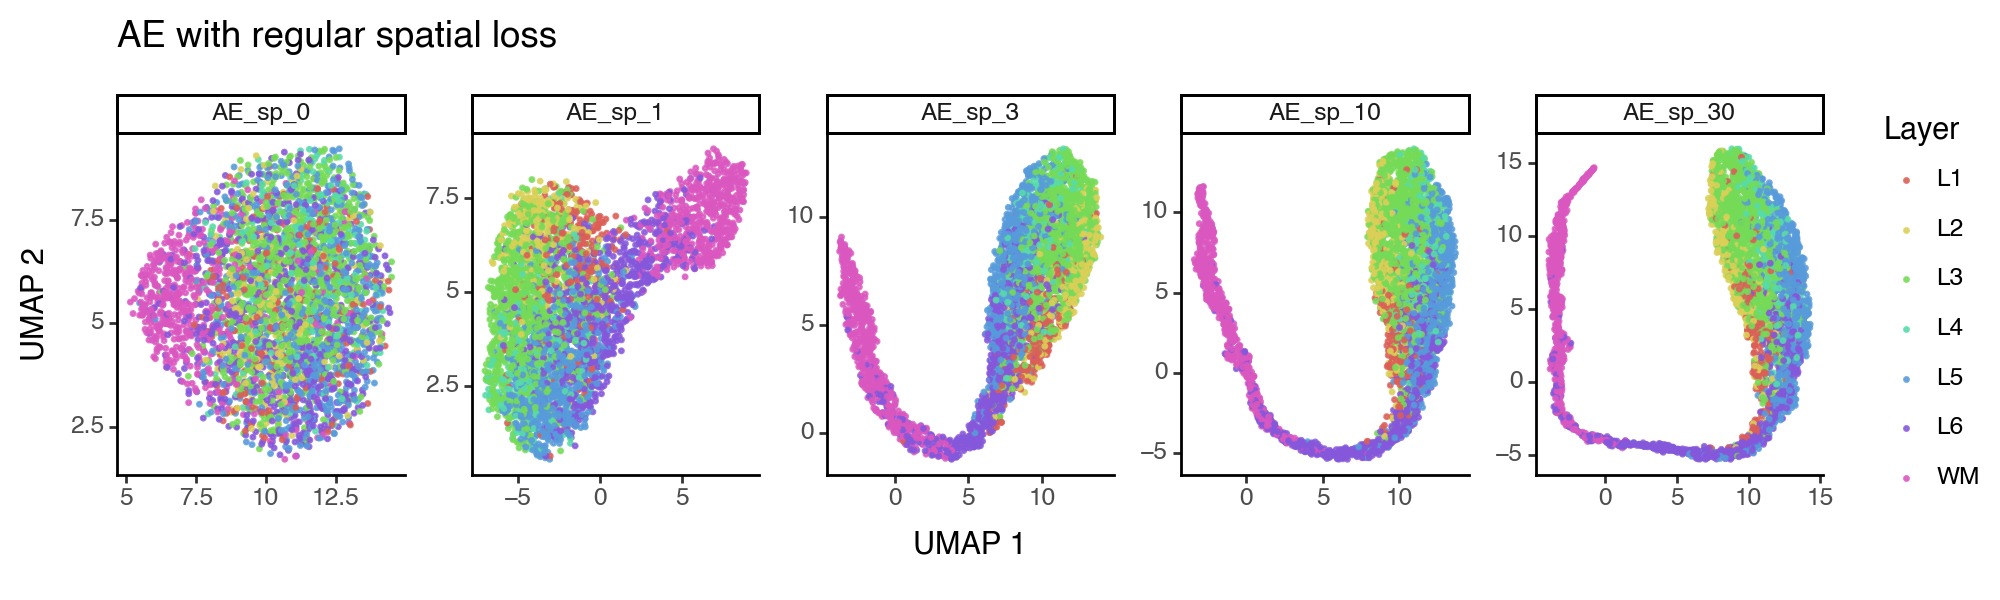

<Figure Size: (1000 x 300)>

In [12]:
# calculate UMAP embeddings
df_umap = []
for name, h in zip(names_list, X_latent):
    adata.obsm[f"X_{name}"] = h
    sc.pp.neighbors(adata, use_rep=f"X_{name}", n_neighbors = 10)
    sc.tl.umap(adata)

    _df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP 1', 'UMAP 2'], index=adata.obs.index)
    _df['name'] = name
    _df['layer'] = adata.obs['layer'].values
    df_umap.append(_df)

df_umap = pd.concat(df_umap)
df_umap['name'] = pd.Categorical(df_umap['name'], categories = names_list)

# visualization
ggplot(df_umap, aes(x = 'UMAP 1', y = 'UMAP 2', color = 'layer')) + \
    facet_wrap('~ name', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'AE with regular spatial loss', color = 'Layer') + \
    theme(figure_size = (10,3))

#### SpatialAE - varying contrastive spatial losses

In [13]:
torch.manual_seed(20230710)
l_sp_losses = [0, 1, 3, 10, 30] # spatial regularization strength

names_list = [f"AE_csp_{l_sp}" for l_sp in l_sp_losses]
X_latent = [] # latent representations

# for each lambda, train a SpatialPCA model
for l_sp in l_sp_losses:
    model = SpatialAutoEncoder.from_rna_model(
        rna_model=baseline, st_adata=adata, layer='log1p',
        spatial_loss=cont_sp_loss, lambda_spatial_loss=l_sp
    )
    model.reduce(lr=3e-4, max_epochs=200, verbose=False, quite=False)

    # store latent representations
    X_latent.append(model.get_latent_representation())

=== Time  0.10s. Total epoch 2. Final Loss: (total) 1.4102. (recon) 1.3898. (orth) 0.0204. (spatial) 0.0000.
=== Time  16.34s. Total epoch 194. Final Loss: (total) 1.4399. (recon) 1.3769. (orth) 0.1302. (spatial) -0.0672.
=== Time  13.05s. Total epoch 129. Final Loss: (total) 0.2991. (recon) 1.3802. (orth) 0.1994. (spatial) -1.2805.
=== Time  8.16s. Total epoch 96. Final Loss: (total) -4.7635. (recon) 1.3817. (orth) 0.2376. (spatial) -6.3828.
=== Time  16.98s. Total epoch 200. Final Loss: (total) -28.3888. (recon) 1.3726. (orth) 0.2386. (spatial) -30.0000.


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:226: UserWarning: Fail to converge. Try to increase 'max_epochs'.


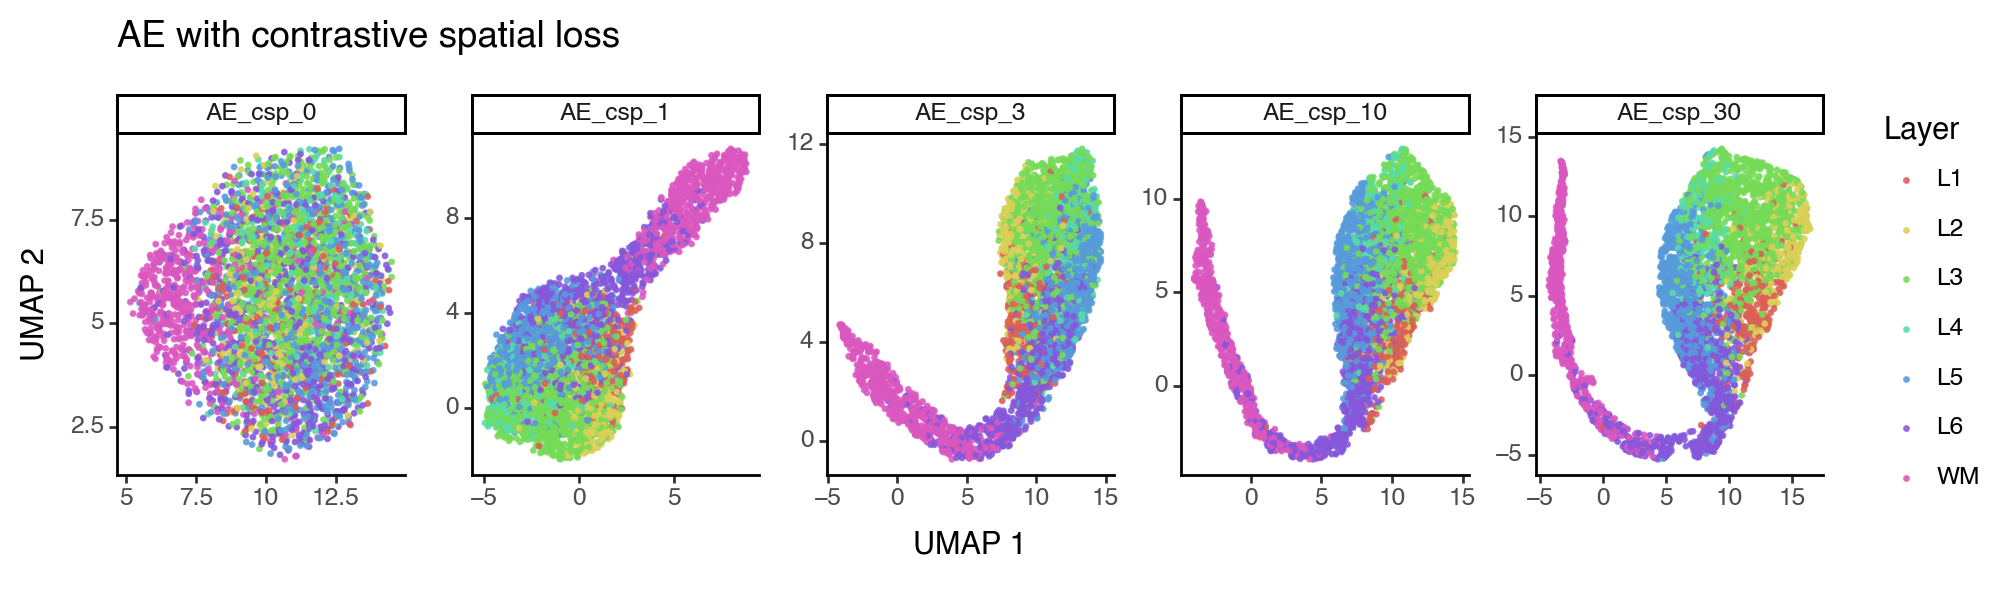

<Figure Size: (1000 x 300)>

In [14]:
# calculate UMAP embeddings
df_umap = []
for name, h in zip(names_list, X_latent):
    adata.obsm[f"X_{name}"] = h
    sc.pp.neighbors(adata, use_rep=f"X_{name}", n_neighbors = 10)
    sc.tl.umap(adata)

    _df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP 1', 'UMAP 2'], index=adata.obs.index)
    _df['name'] = name
    _df['layer'] = adata.obs['layer'].values
    df_umap.append(_df)

df_umap = pd.concat(df_umap)
df_umap['name'] = pd.Categorical(df_umap['name'], categories = names_list)

# visualization
ggplot(df_umap, aes(x = 'UMAP 1', y = 'UMAP 2', color = 'layer')) + \
    facet_wrap('~ name', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'AE with contrastive spatial loss', color = 'Layer') + \
    theme(figure_size = (10,3))